<a href="https://colab.research.google.com/github/rosshalpin/AdvancedML/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/AdvancedML/

/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/My Drive/AdvancedML


In [2]:
import pandas as pd

df = pd.read_csv("tweets.1650486802.csv")

In [3]:
import re

def remove_usernames(text):
  return re.sub(r'@([^\s]+)', '', text)

def remove_hyperlinks(text):
  return re.sub(r'http\S+|www.\S+|https', '', text)

df.text = df.text.apply(remove_usernames)
df.text = df.text.apply(remove_hyperlinks)
df = df.drop_duplicates()
df = df.drop(df.query('sentiment == "neutral"').sample(frac=.64, random_state=109).index)
df.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# import string

# def remove_stopwords(text):
#   word_tokens = word_tokenize(text)
#   filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
#   sentence = " ".join(filtered_sentence)
#   return sentence

#   df.text = df.text.apply(remove_stopwords)

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


Y = pd.get_dummies(df.sentiment).values

max_features = 100

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df.text)

X = pad_sequences(tokenizer.texts_to_sequences(df.text))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=409, shuffle=True)

In [7]:
import torch
torch.cuda.is_available()

True

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

from keras.callbacks import History 
history = History()

embed_dim = 20
lstm_out = 5


model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 42, 20)            2000      
                                                                 
 lstm (LSTM)                 (None, 5)                 520       
                                                                 
 dense (Dense)               (None, 3)                 18        
                                                                 
Total params: 2,538
Trainable params: 2,538
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
batch_size = 32
history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 40, batch_size=batch_size, verbose = 2, callbacks=[history])

Epoch 1/40
34/34 - 22s - loss: 1.0974 - accuracy: 0.3596 - val_loss: 1.0917 - val_accuracy: 0.4127 - 22s/epoch - 650ms/step
Epoch 2/40
34/34 - 6s - loss: 1.0887 - accuracy: 0.4054 - val_loss: 1.0781 - val_accuracy: 0.3908 - 6s/epoch - 190ms/step
Epoch 3/40
34/34 - 6s - loss: 1.0740 - accuracy: 0.4448 - val_loss: 1.0574 - val_accuracy: 0.4454 - 6s/epoch - 181ms/step
Epoch 4/40
34/34 - 6s - loss: 1.0542 - accuracy: 0.4569 - val_loss: 1.0306 - val_accuracy: 0.4869 - 6s/epoch - 186ms/step
Epoch 5/40
34/34 - 6s - loss: 1.0348 - accuracy: 0.4850 - val_loss: 1.0074 - val_accuracy: 0.5087 - 6s/epoch - 180ms/step
Epoch 6/40
34/34 - 6s - loss: 1.0150 - accuracy: 0.5000 - val_loss: 0.9855 - val_accuracy: 0.5218 - 6s/epoch - 180ms/step
Epoch 7/40
34/34 - 6s - loss: 0.9952 - accuracy: 0.5206 - val_loss: 0.9669 - val_accuracy: 0.5611 - 6s/epoch - 176ms/step
Epoch 8/40
34/34 - 6s - loss: 0.9760 - accuracy: 0.5637 - val_loss: 0.9444 - val_accuracy: 0.5786 - 6s/epoch - 180ms/step
Epoch 9/40
34/34 - 6s 

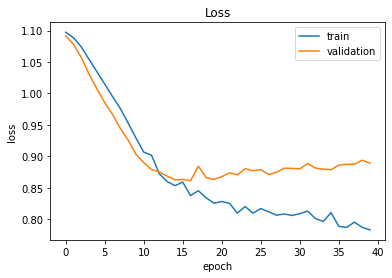

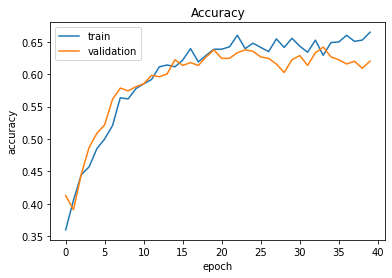

In [19]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [11]:
# model.save('dnn')

In [12]:
# from tensorflow import keras

# try:
#   model = keras.models.load_model('dnn')
# except:
#   model = None

In [13]:
y_pred = model.predict(X_test)

In [14]:
y_pred

array([[0.45570967, 0.31063747, 0.23365282],
       [0.21722607, 0.55184436, 0.23092955],
       [0.13705741, 0.6844023 , 0.17854032],
       ...,
       [0.08743315, 0.61368763, 0.29887918],
       [0.02419468, 0.9347129 , 0.04109238],
       [0.21257225, 0.5199141 , 0.26751363]], dtype=float32)

In [15]:
import operator
# negative, neutral, positive

def get_sentiment(values):
  max_index, max_value = max(enumerate(values), key=operator.itemgetter(1))
  if max_index == 0:
    return "negative"
  if max_index == 1:
    return "neutral"
  if max_index == 2:
    return "positive"
  return "mixed"

In [16]:
y_pred = pd.DataFrame([get_sentiment(vals) for vals in y_pred])[0]
y_test = pd.DataFrame([get_sentiment(vals) for vals in y_test])[0]

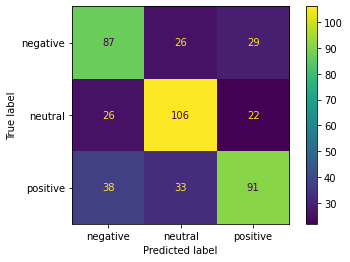

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
cmd.plot()

In [18]:
from sklearn.metrics import classification_report

dnn_report = classification_report(y_test, y_pred, output_dict=True)
print('accuracy: ', dnn_report['accuracy'])
print('macro avg: ', dnn_report['macro avg'])
print('positive: ', dnn_report['positive'])
print('negative: ', dnn_report['negative'])
print('neutral ', dnn_report['neutral'])

accuracy:  0.6200873362445415
macro avg:  {'precision': 0.6198094177480429, 'recall': 0.620905379903815, 'f1-score': 0.6190392227747518, 'support': 458}
positive:  {'precision': 0.6408450704225352, 'recall': 0.5617283950617284, 'f1-score': 0.5986842105263158, 'support': 162}
negative:  {'precision': 0.5761589403973509, 'recall': 0.6126760563380281, 'f1-score': 0.5938566552901023, 'support': 142}
neutral  {'precision': 0.6424242424242425, 'recall': 0.6883116883116883, 'f1-score': 0.664576802507837, 'support': 154}


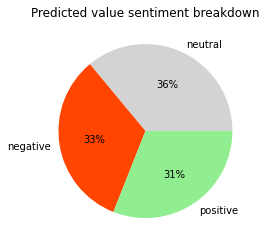

In [48]:
label_colors = {
    "neutral": "lightgrey",
    "negative": "orangered",
    "positive": "lightgreen"
}

pred_counts = y_pred.value_counts(normalize=True) * 100
label = pred_counts.keys()
color= [label_colors[l] for l in label]
plt.pie(pred_counts, labels=label, colors = color, autopct='%.0f%%')
plt.title("Predicted value sentiment breakdown")
plt.show()

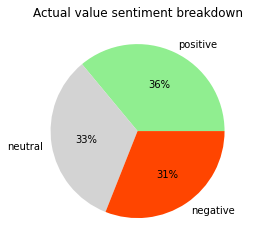

In [49]:
test_counts = y_test.value_counts(normalize=True) * 100
label = test_counts.keys()
color= [label_colors[l] for l in label]
plt.pie(pred_counts, labels=label, colors = color, autopct='%.0f%%')
plt.title("Actual value sentiment breakdown")
plt.show()